In [1]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
from copy import deepcopy
import pickle
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code'))
from model_fitting import initialize_fitting
from utils import roi_utils


In [3]:
device = torch.device('cpu:0')

In [2]:
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: GeForce GTX TITAN X

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


In [3]:
sns.axes_style()
sns.set_style("white")
sns.set_context("notebook", rc={'axes.labelsize': 12.0, 'axes.titlesize': 14.0, 'legend.fontsize': 12.0, 'xtick.labelsize': 12.0, 'ytick.labelsize': 12.0})
sns.set_palette("deep")
plt.rcParams['image.cmap'] = 'viridis'

In [4]:
# Load results of the fitting procedure

subject = 1
n_from_end = 1; # if zero, load most recent; if positive, load second most recent etc.

# fitting_type ='simple_complex_ridge_8ori_4sf'
# fitting_type = 'texture_ridge_8ori_4sf'
fitting_type = 'texture_ridge_8ori_4sf_no_autocorrelations'
# fitting_type = 'texture_ridge_8ori_4sf'
# fitting_type = 'gabor_ridge_8ori_3sf'
# fitting_type = 'gabor_combinations_ridge_8ori_3sf'

root = os.path.dirname(os.path.dirname(os.getcwd()))
folder2load = os.path.join(root, 'model_fits','S%02d'%subject, fitting_type)
# within this folder, assuming we want the most recent version that was saved
files_in_dir = os.listdir(folder2load)
from datetime import datetime
my_dates = [f for f in files_in_dir if 'ipynb' not in f and 'DEBUG' not in f]
my_dates.sort(key=lambda date: datetime.strptime(date, "%b-%d-%Y_%H%M"))
most_recent_date = my_dates[-1-n_from_end]

subfolder2load = os.path.join(folder2load, most_recent_date)
file2load = os.listdir(subfolder2load)[0]
fullfile2load = os.path.join(subfolder2load, file2load)

print('loading from %s\n'%fullfile2load)

out = torch.load(fullfile2load)
print(out.keys())

loading from /user_data/mmhender/imStat/model_fits/S01/texture_ridge_8ori_4sf_no_autocorrelations/Jul-02-2021_1735/all_fit_params

dict_keys(['feature_table_simple', 'sf_tuning_masks_simple', 'ori_tuning_masks_simple', 'cyc_per_stim_simple', 'orients_deg_simple', 'orient_filters_simple', 'feature_table_complex', 'sf_tuning_masks_complex', 'ori_tuning_masks_complex', 'cyc_per_stim_complex', 'orients_deg_complex', 'orient_filters_complex', 'aperture', 'aperture_rf_range', 'models', 'include_autocorrs', 'feature_info', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'best_params', 'lambdas', 'best_lambdas', 'best_losses', 'val_cc', 'val_r2', 'features_each_model_val', 'voxel_feature_correlations_val', 'zscore_features', 'nonlin_fn', 'padding_mode', 'n_prf_sd_out', 'autocorr_output_pix', 'debug'])


In [108]:
my_dates

['Jun-18-2021_1833',
 'Jun-18-2021_1837',
 'Jun-18-2021_1853',
 'Jun-18-2021_2025',
 'Jun-18-2021_2030',
 'Jun-18-2021_2243',
 'Jun-19-2021_1140',
 'Jun-19-2021_2213',
 'Jun-28-2021_0406',
 'Jun-28-2021_2133',
 'Jun-29-2021_1429',
 'Jun-29-2021_1825',
 'Jul-01-2021_0002',
 'Jul-02-2021_1735',
 'Jul-03-2021_0711']

In [5]:
# Pulling out useful elements from the saved data

feature_table_complex = out['feature_table_complex']
feature_table_simple = out['feature_table_simple']
orient_list = np.round(np.array(feature_table_complex['orientation'])/np.pi*180,1)
a,orient_ind_list = np.unique(orient_list,return_inverse=True)
sf_list = np.array(feature_table_complex['cycles per stimulus'])
a,sf_ind_list = np.unique(sf_list,return_inverse=True)

aperture = out['aperture']
cyc_per_stim  = out['cyc_per_stim_complex']
orients_deg = out['orients_deg_complex']

sf_tuning_masks_simple = out['sf_tuning_masks_simple']
ori_tuning_masks_simple = out['ori_tuning_masks_simple']
orient_filters_simple = out['orient_filters_simple']
sf_tuning_masks_complex = out['sf_tuning_masks_complex']
ori_tuning_masks_complex = out['ori_tuning_masks_complex']
orient_filters_complex = out['orient_filters_complex']

voxel_mask = out['voxel_mask']
brain_nii_shape = out['brain_nii_shape']
image_order = out['image_order']
voxel_idx = out['voxel_index'][0]
voxel_roi = out['voxel_roi']
if len(voxel_roi)==2:
    [roi_labels_retino, roi_labels_categ] = deepcopy(voxel_roi)
    roi_labels_retino = roi_labels_retino[voxel_idx]
    roi_labels_categ = roi_labels_categ[voxel_idx]

val_cc = out['val_cc']
val_r2 = out['val_r2']
best_params = out['best_params']
best_lambdas = out['best_lambdas']
best_losses = out['best_losses']
lambdas = out['lambdas']

features_each_model_val = out['features_each_model_val']
voxel_feature_correlations_val = out['voxel_feature_correlations_val']
   
feature_info = deepcopy(out['feature_info'])
feature_type_labels, feature_type_names = feature_info

feature_type_labels_adj = deepcopy(feature_type_labels)
feature_type_labels_adj[feature_type_labels_adj<4] = 0.0
feature_type_labels_adj[feature_type_labels_adj>=4] = feature_type_labels_adj[feature_type_labels_adj>=4] - 3
feature_type_names_adj = ['pixel']
for ii in np.arange(4,len(feature_type_names)):
    feature_type_names_adj.append(feature_type_names[ii]) 
                        
feature_type_names = feature_type_names_adj
feature_type_labels = feature_type_labels_adj
    
n_feature_types = len(feature_type_names)
    
zscore_features = out['zscore_features']
print('zscore_features=%s\n'%zscore_features)
nonlin_fn = out['nonlin_fn']
padding_mode = out['padding_mode']
autocorr_output_pix = out['autocorr_output_pix']
n_prf_sd_out = out['n_prf_sd_out']
models = out['models']

# Best params[0] = x,y,sigma for pRF estimates [n_voxels x 3]
print(np.shape(best_params[0]))
# Best params[1] = best weights [n_voxels x nFeatures]
print(np.shape(best_params[1]))

best_models = best_params[0]
best_model_inds = best_params[5]
best_ecc  = np.sqrt(np.square(best_models[:,0]) + np.square(best_models[:,1]))
best_ang  = np.arctan2(best_models[:,1], best_models[:,0])
best_size = best_models[:,2]

feature_weights = best_params[1]

n_sf = len(cyc_per_stim)
n_ori = len(orients_deg)
n_voxels = np.shape(feature_weights)[0]
n_features_total = np.shape(feature_weights)[1]

# also listing roi names here
group_names = ['V1', 'V2', 'V3', 'hV4', 'V3ab', 'LO', 'IPS', 'VO', 'PHC', 'MT', 'MST', 'other']
group = [[1,2],[3,4],[5,6], [7], [16, 17], [14, 15], [18,19,20,21,22,23], [8, 9], [10,11], [13], [12], [24,25,0]]


if 'combs_zstats' in out.keys():
    combs_zstats = out['combs_zstats']
else:
    combs_stats=None

zscore_features=True

(14913, 3)
(14913, 1012)


In [19]:
feature_table_simple

,cycles per stimulus,pix per stimulus,orientation,cycles per filter,pix per filter,gauss. env. radius (pix),phase
0,3.0,12,0.000000,2.8,12.0,2.891,0.000000
1,3.0,12,0.000000,2.8,12.0,2.891,1.570796
2,3.0,12,0.392699,2.8,12.0,2.891,0.000000
3,3.0,12,0.392699,2.8,12.0,2.891,1.570796
4,3.0,12,0.785398,2.8,12.0,2.891,0.000000
...,...,...,...,...,...,...,...
59,72.0,297,1.963495,2.8,12.0,2.891,1.570796
60,72.0,297,2.356194,2.8,12.0,2.891,0.000000
61,72.0,297,2.356194,2.8,12.0,2.891,1.570796
62,72.0,297,2.748894,2.8,12.0,2.891,0.000000


Text(0.5, 0.98, 'S01, texture_ridge_8ori_4sf_no_autocorrelations')

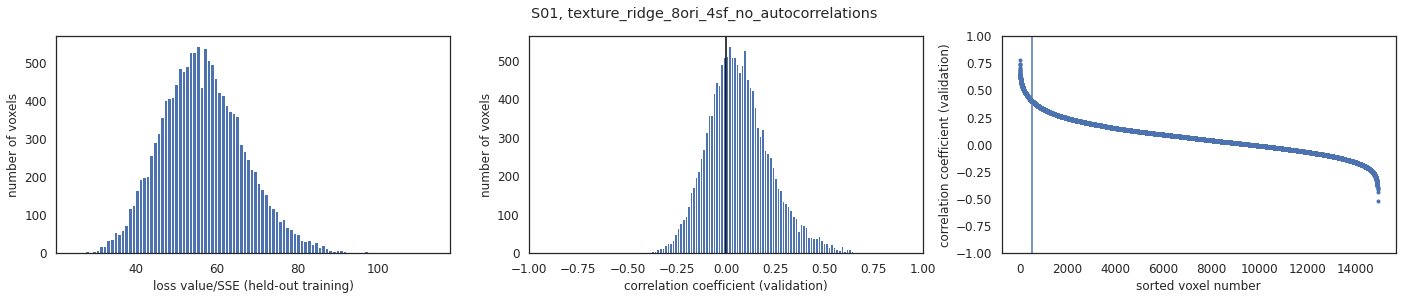

In [6]:
# Plot summary of performance

cclims = [-1,1]
# losslims = [20,120]
losslims = [350,850]
plt.figure(figsize=(24,4));

plt.subplot(1,3,1)
plt.hist(best_losses,100)
# plt.xlim(losslims)
# plt.xlim([500,2000])
plt.xlabel('loss value/SSE (held-out training)');
plt.ylabel('number of voxels');

plt.subplot(1,3,2)
plt.hist(val_cc,100)
# plt.hist(val_cc,100)
# plt.xlim([-0.2, 0.8])
plt.xlim(cclims)
plt.xlabel('correlation coefficient (validation)');
plt.ylabel('number of voxels');
plt.axvline(0,color='k')

plt.subplot(1,3,3)

# plt.hist(val_r2,100)
# # plt.hist(val_cc,100)
# # plt.xlim([-0.2, 0.8])
# plt.xlabel('r2 (validation)');
# plt.ylabel('number of voxels');
# plt.axvline(0,color='k')


plt.plot(np.sort(val_cc)[::-1],'.')
plt.axvline(500)
plt.ylim(cclims)
plt.xlabel('sorted voxel number')
plt.ylabel('correlation coefficient (validation)')

plt.suptitle('S%02d, %s'%(subject, fitting_type))

Text(0.5, 1.0, 'S01, texture_ridge_8ori_4sf_no_autocorrelations')

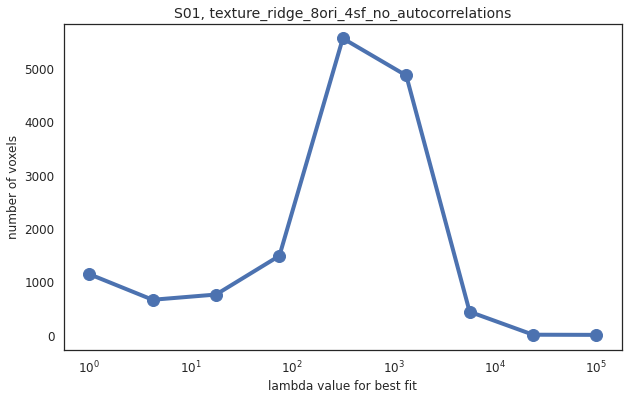

In [7]:
plt.figure(figsize=(10,6))
plt.plot(lambdas, [np.sum(best_lambdas==k) for k in range(len(lambdas))], lw=4, marker='o', ms=12)
plt.xscale('log');
plt.xlabel('lambda value for best fit');
plt.ylabel('number of voxels');
plt.title('S%02d, %s'%(subject, fitting_type))

In [8]:
# Gather text labels for all ROIs

nsd_root, stim_root, beta_root, mask_root = initialize_fitting.get_paths()
ret, face, place = roi_utils.load_roi_label_mapping(nsd_root, subject, verbose=True)
max_ret_label = np.max(ret[0])
face[0] = face[0]+max_ret_label
max_face_label = np.max(face[0])
place[0] = place[0]+max_face_label
print(face)
print(place)
print(np.unique(roi_labels_categ))

ret_group_names = roi_utils.ret_group_names
ret_group_inds =  roi_utils.ret_group_inds
n_rois_ret = len(ret_group_names)

categ_group_names = list(np.concatenate((face[1], place[1])))
categ_group_inds =  list(np.concatenate((face[0], place[0])))
n_rois_categ = len(categ_group_names)

n_rois = n_rois_ret + n_rois_categ

[1, 2, 3, 4, 5, 6, 7]
['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4']
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4', 'VO1', 'VO2', 'PHC1', 'PHC2', 'TO2', 'TO1', 'LO2', 'LO1', 'V3B', 'V3A', 'IPS0', 'IPS1', 'IPS2', 'IPS3', 'IPS4', 'IPS5', 'SPL1', 'FEF']
[1, 2, 3, 4, 5]
['OFA', 'FFA-1', 'FFA-2', 'mTL-faces', 'aTL-faces']
[1, 2, 3]
['OPA', 'PPA', 'RSC']
[array([26, 27, 28, 29, 30]), ['OFA', 'FFA-1', 'FFA-2', 'mTL-faces', 'aTL-faces']]
[array([31, 32, 33]), ['OPA', 'PPA', 'RSC']]
[-1.  0. 26. 27. 28. 30. 31. 32. 33.]


In [50]:
len(ret_group_inds)

12

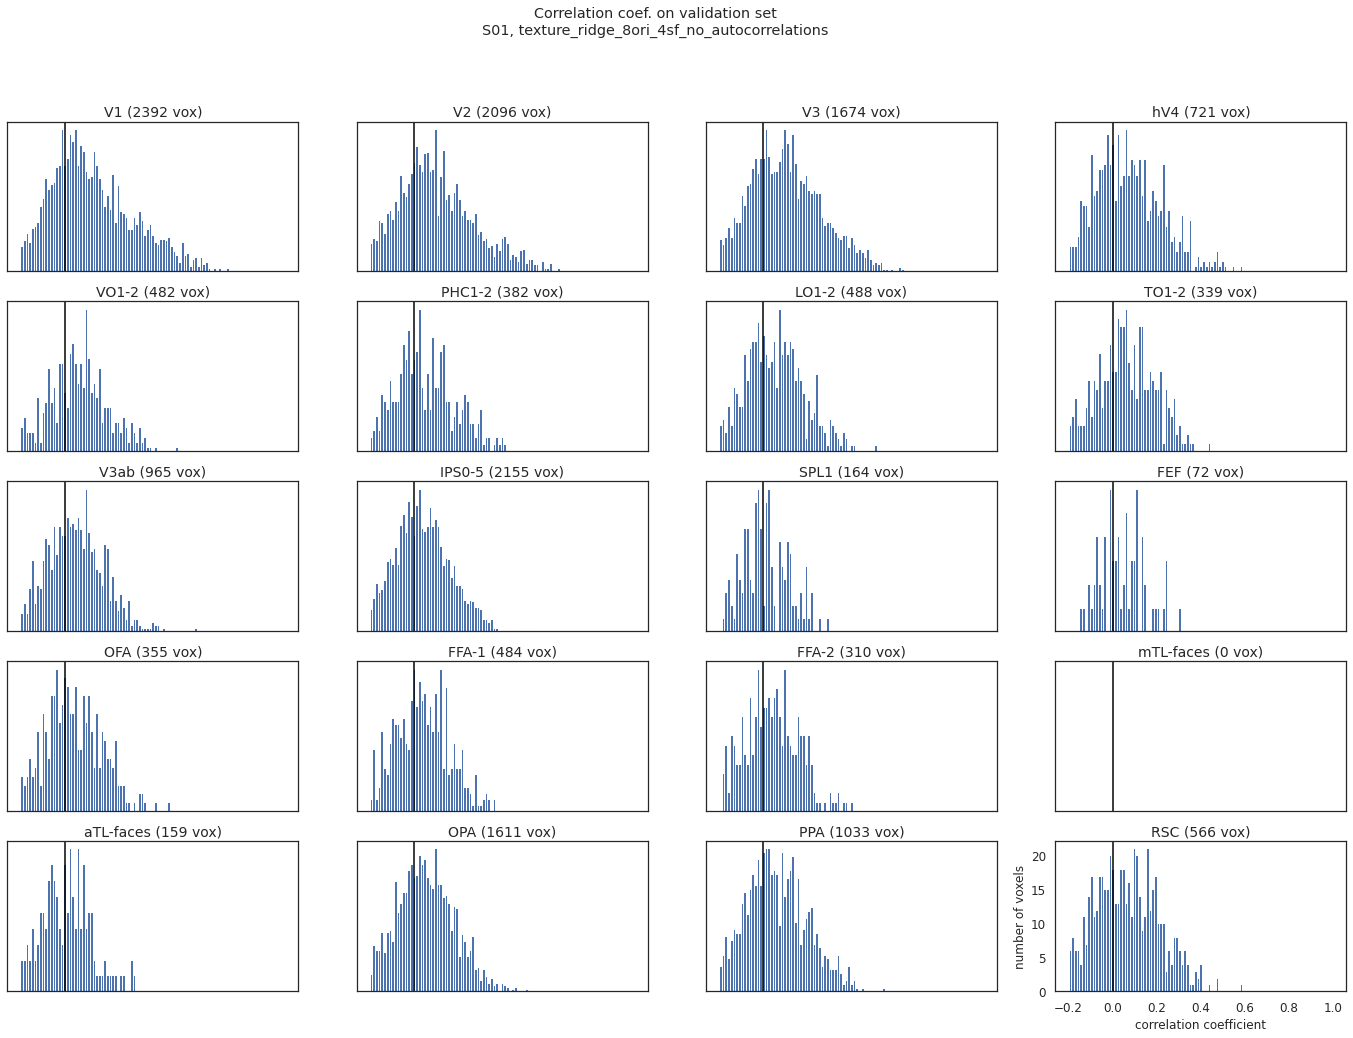

In [9]:
# Plot correlation coefficient for each ROI separately.

plt.figure(figsize=(24,16))
npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

for rr in range(n_rois):
        
    if rr<n_rois_ret:
        inds_this_roi = np.isin(roi_labels_retino, ret_group_inds[rr])
        rname = ret_group_names[rr]
    else:
        inds_this_roi = np.isin(roi_labels_categ, categ_group_inds[rr-n_rois_ret])
        rname = categ_group_names[rr-n_rois_ret]
        
    plt.subplot(npx,npy,rr+1)

    h = plt.hist(val_cc[inds_this_roi], bins=np.linspace(-0.2,1,100))

    if rr==n_rois-1:
        plt.xlabel('correlation coefficient')
        plt.ylabel('number of voxels')
    else:
        plt.xticks([]);plt.yticks([])
        
    plt.axvline(0,color='k')
    
    plt.title('%s (%d vox)'%(rname, np.sum(inds_this_roi)))

plt.suptitle('Correlation coef. on validation set\nS%02d, %s'%(subject, fitting_type));

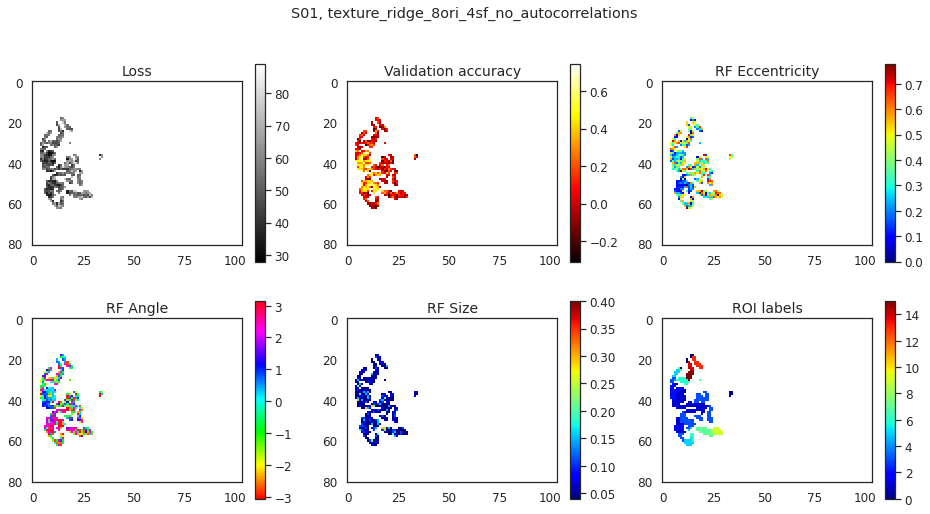

In [10]:
# Visualize some basic properties of pRFs for each voxel, in volume space
# Should be sanity check for dorsal/visual distinctions, esp w/r/t RF angle estimates

sys.path.append(os.path.join(root,'code'))
from utils import file_utility

volume_loss = file_utility.view_data(brain_nii_shape, voxel_idx, best_losses)
volume_cc   = file_utility.view_data(brain_nii_shape, voxel_idx, val_cc)
volume_ecc  = file_utility.view_data(brain_nii_shape, voxel_idx, best_ecc)
volume_ang  = file_utility.view_data(brain_nii_shape, voxel_idx, best_ang)
volume_size = file_utility.view_data(brain_nii_shape, voxel_idx, best_size)
volume_roi = file_utility.view_data(brain_nii_shape, voxel_idx, roi_labels_retino)

slice_idx = 40
fig = plt.figure(figsize=(16,8))
plt.subplot(2,3,1)
plt.title('Loss')
plt.imshow(volume_loss[:,:,slice_idx], cmap='gray', interpolation='None')
plt.colorbar()
plt.subplot(2,3,2)
plt.title('Validation accuracy')
plt.imshow(volume_cc[:,:,slice_idx], cmap='hot', interpolation='None')
plt.colorbar()
plt.subplot(2,3,3)
plt.title('RF Eccentricity')
plt.imshow(volume_ecc[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()
plt.subplot(2,3,4)
plt.title('RF Angle')
plt.imshow(volume_ang[:,:,slice_idx], cmap='hsv', interpolation='None')
plt.colorbar()
plt.subplot(2,3,5)
plt.title('RF Size')
plt.imshow(volume_size[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()
plt.subplot(2,3,6)
plt.title('ROI labels')
plt.imshow(volume_roi[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()

plt.suptitle('S%02d, %s'%(subject, fitting_type));

In [68]:
voxel_idx[0]

array([148208, 148209, 148288, ..., 606447, 606448, 606530])

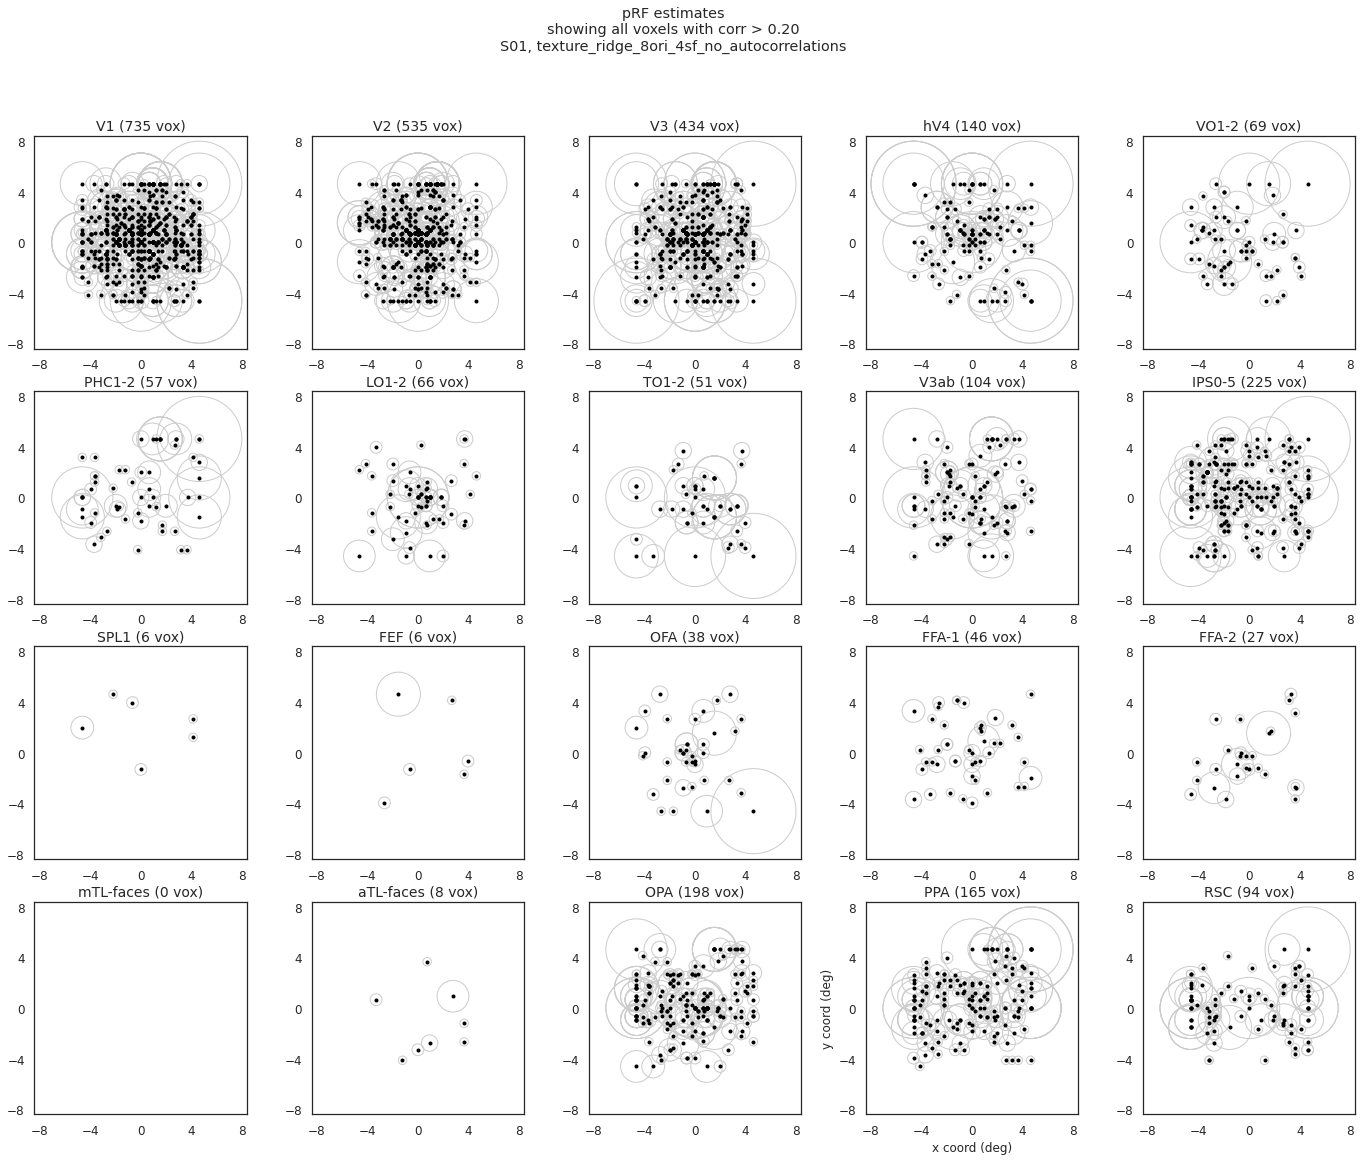

In [11]:
# Plot spatial RF estimates
import matplotlib

eccen_deg = 8.4
best_models_deg = best_models*eccen_deg

plt.figure(figsize=(24,18))

cc_cutoff = 0.20
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil(n_rois/npx))

for rr in range(n_rois):
        
    if rr<n_rois_ret:
        inds_this_roi = np.isin(roi_labels_retino, ret_group_inds[rr])
        rname = ret_group_names[rr]
    else:
        inds_this_roi = np.isin(roi_labels_categ, categ_group_inds[rr-n_rois_ret])
        rname = categ_group_names[rr-n_rois_ret]
           
    abv_thresh = val_cc>cc_cutoff
    inds2use = np.where(np.logical_and(inds_this_roi, abv_thresh))[0]
    
    plt.subplot(npx,npy,rr+1)
    ax = plt.gca()

    for vi, vidx in enumerate(inds2use):
       
        plt.plot(best_models_deg[vidx,0], best_models_deg[vidx,1],'.',color='k')
        circ = matplotlib.patches.Circle((best_models_deg[vidx,0], best_models_deg[vidx,1]), best_models_deg[vidx,2], color = [0.8, 0.8, 0.8], fill=False)
        ax.add_artist(circ)
   
    plt.axis('square')
    
    plt.xlim([-eccen_deg, eccen_deg])
    plt.ylim([-eccen_deg, eccen_deg])
    plt.xticks(np.arange(-8,9,4))
    plt.yticks(np.arange(-8,9,4))
    if rr==n_rois-2:
        plt.xlabel('x coord (deg)')
        plt.ylabel('y coord (deg)')
    plt.title('%s (%d vox)'%(rname, len(inds2use)))

plt.suptitle('pRF estimates\nshowing all voxels with corr > %.2f\nS%02d, %s'%(cc_cutoff, subject, fitting_type));


['pixel', 'complex_feature_means', 'simple_feature_means', 'complex_within_scale_crosscorrs', 'simple_within_scale_crosscorrs', 'complex_across_scale_crosscorrs', 'simple_across_scale_crosscorrs']


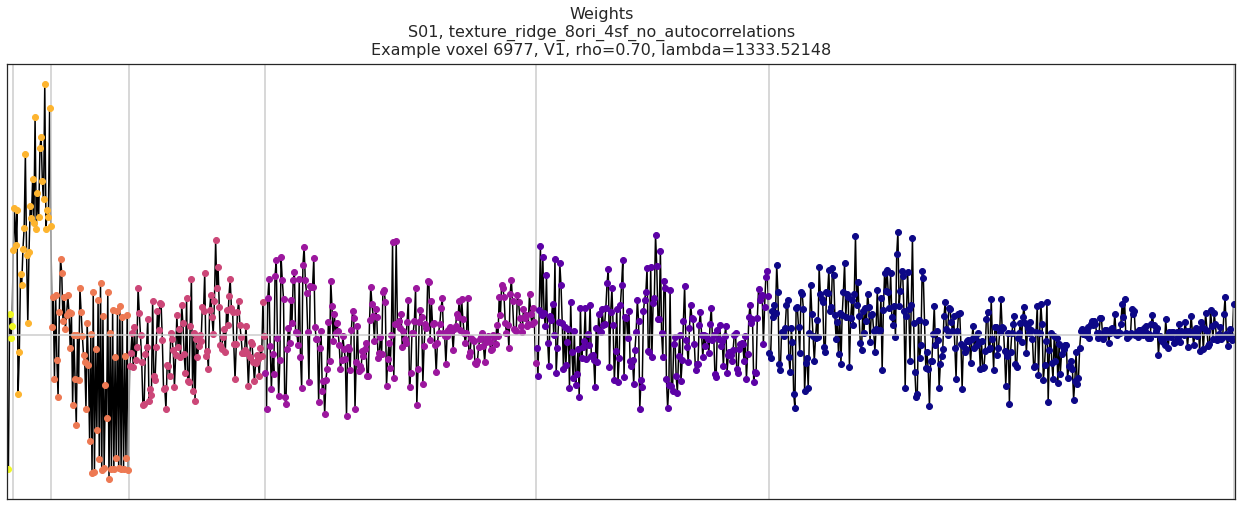

In [18]:
# Plotting weights for all features in encoding model

from copy import deepcopy

vox2plot = np.argsort(np.nan_to_num(val_cc))[-5] # choosing vox w best validation set performance
# vox2plot = 929

colors = cm.plasma(np.linspace(0,1,n_feature_types))
colors = np.flipud(colors)
# vox2plot = np.random.randint(0,len(val_cc),1)

vv=vox2plot
plt.figure(figsize=(22,8))

wts = feature_weights[vv,:,]
plt.plot(wts,'-',color='k')

lh=[]
f_count=0
for ft in range(n_feature_types):    
    f_count = f_count+np.sum(feature_type_labels==ft)
    plt.axvline(f_count-0.5,color=[0.8, 0.8, 0.8])
    inds = np.where(feature_type_labels==ft)[1]
    h=plt.plot(inds, feature_weights[vv,inds],'o',color=colors[ft,:])
    lh.append(h)
    
plt.axhline(0,color=[0.8, 0.8, 0.8])
if vi==(npx-1)*npy:
    plt.xlabel('feature')
#     plt.ylabel('weight')
else:
    plt.xticks([]); 
    plt.yticks([])

roi_ind_ret = np.where([np.isin(roi_labels_retino[vv], ret_group_inds[ii]) for ii in range(len(ret_group_inds))])[0]
roi_ind_categ = np.where([np.isin(roi_labels_categ[vv], categ_group_inds[ii]) for ii in range(len(categ_group_inds))])[0]
if len(roi_ind_ret)==0:
    rname = categ_group_names[roi_ind_categ[0]]
elif len(roi_ind_categ)==0:
    rname = ret_group_names[roi_ind_ret[0]]
else:
    rname = '%s/%s'%(ret_group_names[roi_ind_ret[0]],categ_group_names[roi_ind_categ[0]])
    
plt.title(''%())
plt.xlim([-1, n_features_total]);
plt.suptitle('Weights\nS%02d, %s\nExample voxel %d, %s, rho=%.2f, lambda=%.5f'%( subject, fitting_type,vv,rname, val_cc[vv],lambdas[best_lambdas[vv]]),fontsize=16);
# plt.legend(lh, feature_type_names)

print(feature_type_names)

In [26]:
np.where(np.sum(feature_weights==0, axis=1)>0)[0].shape

(6886,)

In [33]:
has_zeros = np.where(np.sum(feature_weights==0, axis=1)>0)[0]
no_zeros = np.where(np.sum(feature_weights==0, axis=1)==0)[0]

mm1 = np.unique(best_model_inds[has_zeros])
mm2 = np.unique(best_model_inds[no_zeros])

np.any(np.isin(mm1, mm2))
np.any(np.isin(mm2, mm1))

False

In [44]:
mm1

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  77,  78,
        79,  80,  81,  82,  97,  98,  99, 100, 101, 102, 117, 118, 119,
       120, 121, 122, 137, 138, 139, 140, 141, 142, 157, 158, 159, 160,
       161, 162, 177, 178, 179, 180, 181, 182, 197, 198, 199, 200, 201,
       202, 217, 218, 219, 220, 221, 222, 237, 238, 239, 240, 241, 242,
       257, 258, 259, 260, 261, 262, 277, 278, 279, 280, 281, 282, 297,
       298, 299, 300, 301, 302, 317, 318, 319, 320, 321, 322, 337, 338,
       339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351,
       352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364,
       365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 37

In [43]:
np.sum(feature_weights[best_model_inds==0,:]==0, axis=1)

array([912, 912, 912, 912, 912, 912, 912, 912])

In [37]:
np.mean(val_cc[no_zeros])

0.08463124

In [38]:
np.mean(val_cc[has_zeros])

0.044233974

In [41]:
len(has_zeros)

6886

In [42]:
len(no_zeros)

8027

Text(0.5, 0, 'features')

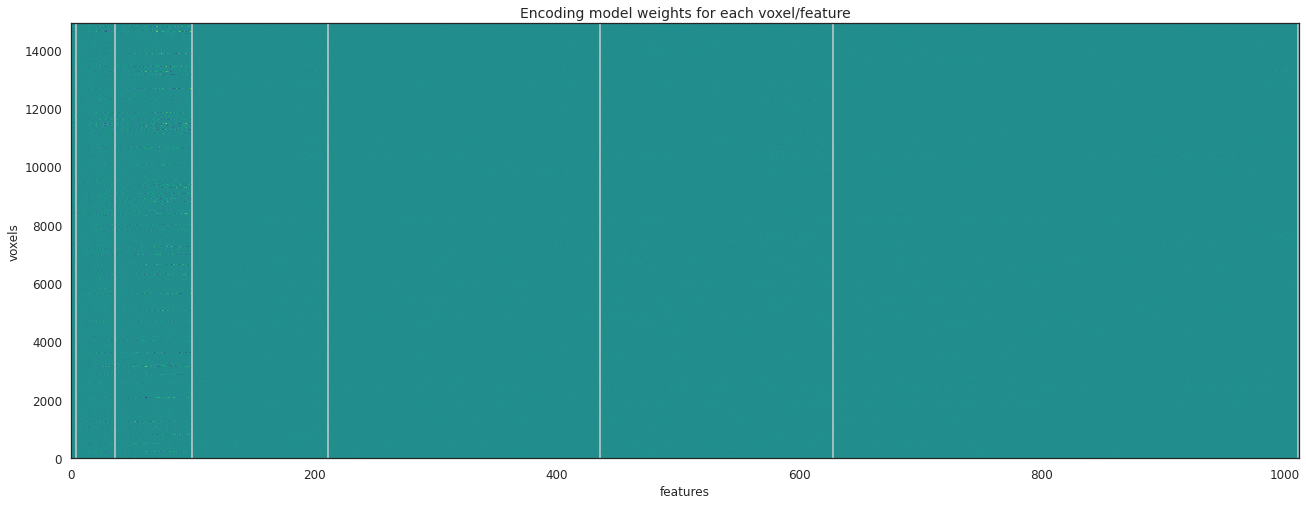

In [21]:
plt.figure(figsize=(22,8));
plt.pcolormesh(feature_weights)
plt.title('Encoding model weights for each voxel/feature')
f_count=0
for ft in range(n_feature_types):    
    f_count = f_count+np.sum(feature_type_labels==ft)
    plt.axvline(f_count-0.5,color=[0.8, 0.8, 0.8])
plt.ylabel('voxels')
plt.xlabel('features')

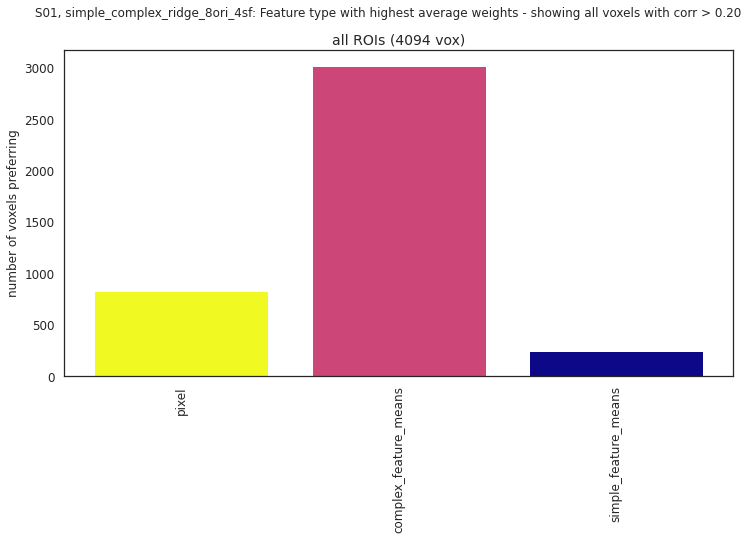

In [104]:
# Plot histogram of the sf "tuning preferences" based on correlation coefficients
plt.figure(figsize=(12,6))
npx = np.ceil(np.sqrt(n_rois))
npy = np.ceil(n_rois/npx)

colors = cm.plasma(np.linspace(0,1,n_feature_types))
colors = np.flipud(colors)

mean_weight_each_type = np.concatenate([np.expand_dims(np.mean(feature_weights[:,feature_type_labels[0]==ff], axis=1),axis=1) for ff in range(len(feature_type_names))], axis=1)
max_wt = np.argmax(mean_weight_each_type, axis=1)

# max_wt = feature_type_labels[0][np.argmax(feature_weights,axis=1)]

cc_cutoff = 0.2

abv_thresh = val_cc>cc_cutoff
inds2use = abv_thresh

unvals, counts = np.unique(max_wt[inds2use], return_counts=True)
for ff in range(n_feature_types):
    plt.bar(unvals[ff], counts[ff], color=colors[ff,:])

plt.xticks(ticks=np.arange(0,n_feature_types),labels=feature_type_names,rotation=90)

# plt.xlabel('feature type')
plt.ylabel('number of voxels preferring')

plt.title('all ROIs (%d vox)'%( np.sum(inds2use)))

plt.suptitle('S%02d, %s: Feature type with highest average weights - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


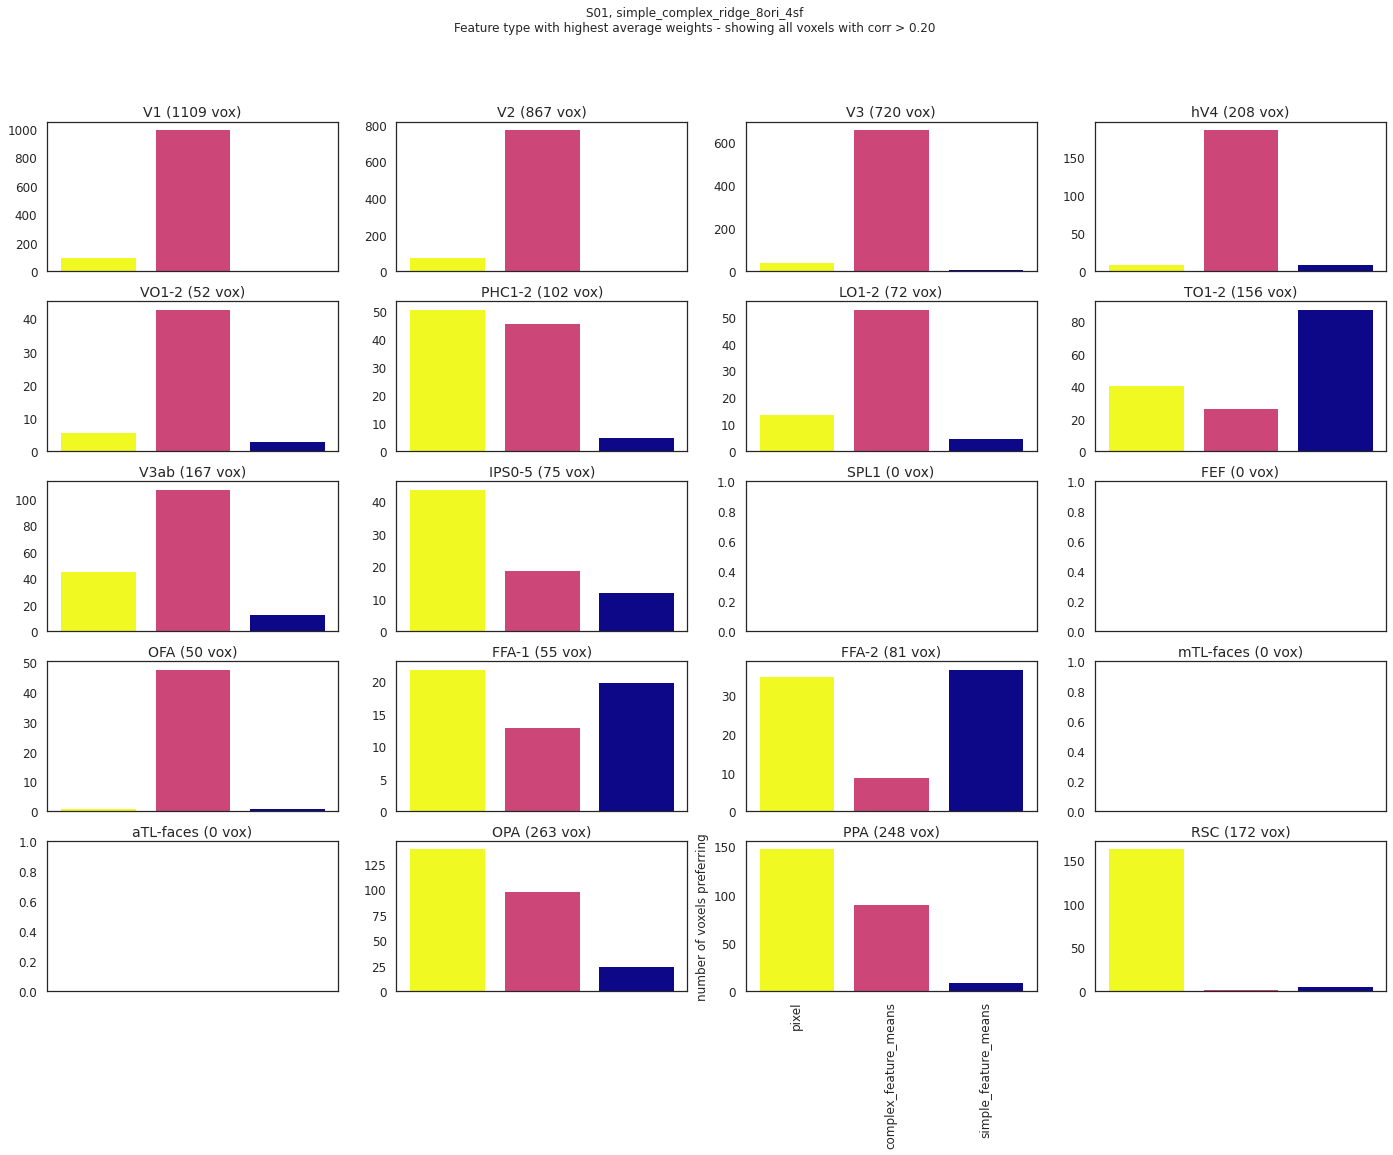

In [105]:
# Plot histogram of the best feature class, based on weights
plt.figure(figsize=(24,16))
npx = np.ceil(np.sqrt(n_rois))
npy = np.ceil(n_rois/npx)

colors = cm.plasma(np.linspace(0,1,n_feature_types))
colors = np.flipud(colors)

mean_weight_each_type = np.concatenate([np.expand_dims(np.mean(feature_weights[:,feature_type_labels[0]==ff], axis=1),axis=1) for ff in range(len(feature_type_names))], axis=1)
max_wt = np.argmax(mean_weight_each_type, axis=1)

# max_wt = feature_type_labels[0][np.argmax(feature_weights,axis=1)]

cc_cutoff = 0.2

for rr in range(n_rois):
        
    if rr<n_rois_ret:
        inds_this_roi = np.isin(roi_labels_retino, ret_group_inds[rr])
        rname = ret_group_names[rr]
    else:
        inds_this_roi = np.isin(roi_labels_categ, categ_group_inds[rr-n_rois_ret])
        rname = categ_group_names[rr-n_rois_ret]
        
    abv_thresh = val_cc>cc_cutoff
    inds2use = np.logical_and(inds_this_roi, abv_thresh)
    
    plt.subplot(npx,npy,rr+1)
    
    unvals, counts = np.unique(max_wt[inds2use], return_counts=True)
    for ff in range(len(unvals)):
        plt.bar(unvals[ff], counts[ff], color=colors[ff,:])
 
    plt.xticks(ticks=np.arange(0,n_feature_types),labels=feature_type_names,rotation=90)

    if rr==n_rois-2:
        plt.ylabel('number of voxels preferring')
    else:
        plt.xticks([])
#         plt.yticks([])

    plt.title('%s (%d vox)'%(rname, np.sum(inds2use)))

# plt.suptitle('S%02d, %s\nFeature type where max weight occured - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));
plt.suptitle('S%02d, %s\nFeature type with highest average weights - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));

In [16]:
# Plot histogram of the best feature class, based on weights
plt.figure(figsize=(24,16))
npx = np.ceil(np.sqrt(n_rois))
npy = np.ceil(n_rois/npx)

colors = cm.plasma(np.linspace(0,1,n_feature_types))
colors = np.flipud(colors)

mean_cc_each_type = np.concatenate([np.expand_dims(np.mean(voxel_feature_correlations_val[:,feature_type_labels[0]==ff], axis=1),axis=1) for ff in range(len(feature_type_names))], axis=1)
max_cc = np.argmax(mean_cc_each_type, axis=1)

# max_wt = feature_type_labels[0][np.argmax(feature_weights,axis=1)]

cc_cutoff = 0.2

for rr in range(n_rois-1):
        
    inds_this_roi = np.isin(voxel_roi, group[rr])
    abv_thresh = val_cc>cc_cutoff
    inds2use = np.logical_and(inds_this_roi, abv_thresh)
    
    plt.subplot(npx,npy,rr+1)
    
    unvals, counts = np.unique(max_cc[inds2use], return_counts=True)
    for ff in range(len(unvals)):
        plt.bar(unvals[ff], counts[ff], color=colors[ff,:])
    
#     h = plt.hist(max_wt[inds2use], bins=np.arange(0,n_feature_types+0.01,1)-0.5, color=colors);
    
    plt.xticks(ticks=np.arange(0,n_feature_types),labels=feature_type_names,rotation=90)
# #     plt.xticks(np.round(cyc_per_stim[[0,4]+list(np.arange(6,n_sf))],1))
#     plt.xlim([np.min(better_bin_edges), np.max(better_bin_edges)])
    
    if rr==n_rois-2:
#         plt.xlabel('feature type')
        plt.ylabel('number of voxels preferring')
    else:
        plt.xticks([])
#         plt.yticks([])

    plt.title('%s (%d vox)'%(group_names[rr], np.sum(inds2use)))

# plt.suptitle('S%02d, %s\nFeature type where max weight occured - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));
plt.suptitle('S%02d, %s\nFeature type with highest average corr - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));

TypeError: 'NoneType' object is not subscriptable

<Figure size 1728x1152 with 0 Axes>

In [17]:
# Plotting correlation of voxel's resp with each feature

from copy import deepcopy

vox2plot = np.argsort(np.nan_to_num(val_cc))[-3] # choosing vox w best validation set performance

colors = cm.plasma(np.linspace(0,1,len(feature_type_names)))
colors = np.flipud(colors)
# vox2plot = np.random.randint(0,len(val_cc),1)

vv=vox2plot
plt.figure(figsize=(22,8))

corrs = voxel_feature_correlations_val[vv,:,]
plt.plot(corrs,'-',color='k')

lh=[]
f_count=0
for ft in range(len(feature_type_names)):    
    f_count = f_count+np.sum(feature_type_labels==ft)
    plt.axvline(f_count-0.5,color=[0.8, 0.8, 0.8])
    inds = np.where(feature_type_labels==ft)[1]
    h=plt.plot(inds, voxel_feature_correlations_val[vv,inds],'o',color=colors[ft,:])
    lh.append(h)
    
plt.axhline(0,color=[0.8, 0.8, 0.8])
if vi==(npx-1)*npy:
    plt.xlabel('feature')
#     plt.ylabel('weight')
else:
    plt.xticks([]); 
    plt.yticks([])

roi_ind = np.where([np.isin(voxel_roi[vv], group[ii]) for ii in range(len(group))])[0][0]
plt.title(''%())
plt.xlim([-1, n_features_total]);
plt.suptitle('Correlation w each feature\nS%02d, %s\nExample voxel %d, %s, rho=%.2f, lambda=%.5f'%( subject, fitting_type,vv,group_names[roi_ind], val_cc[vv],lambdas[best_lambdas[vv]]),fontsize=16);
# plt.legend(lh, feature_type_names)

print(feature_type_names)

TypeError: 'NoneType' object is not subscriptable

<Figure size 1584x576 with 0 Axes>

Text(0.5, 0, 'features')

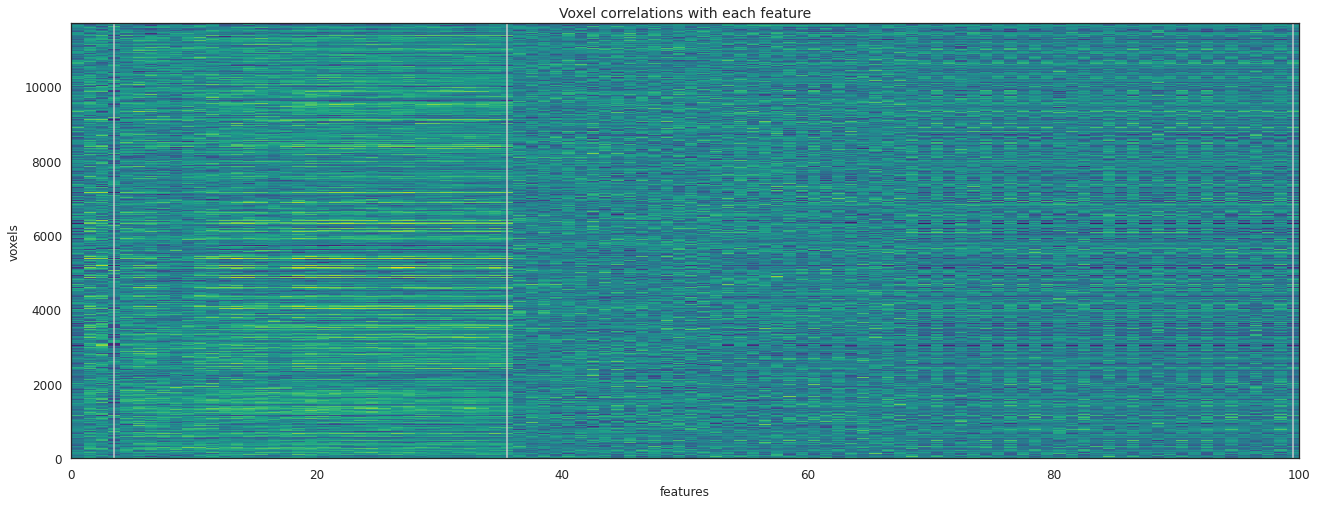

In [32]:
plt.figure(figsize=(22,8));
plt.pcolormesh(voxel_feature_correlations_val)
plt.title('Voxel correlations with each feature')
f_count=0
for ft in range(n_feature_types):    
    f_count = f_count+np.sum(feature_type_labels==ft)
    plt.axvline(f_count-0.5,color=[0.8, 0.8, 0.8])
plt.ylabel('voxels')
plt.xlabel('features')

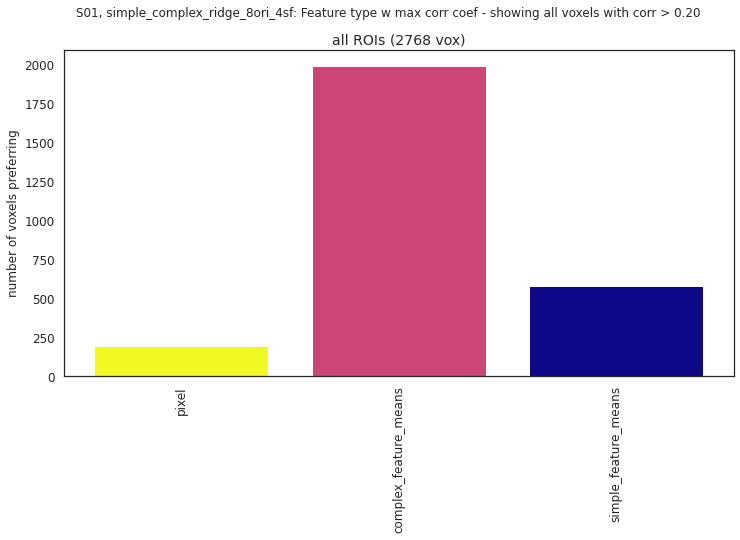

In [38]:
# Plot histogram of the sf "tuning preferences" based on correlation coefficients
plt.figure(figsize=(12,6))
npx = np.ceil(np.sqrt(n_rois))
npy = np.ceil(n_rois/npx)

colors = cm.plasma(np.linspace(0,1,n_feature_types))
colors = np.flipud(colors)

max_wt = feature_type_labels[0][np.argmax(voxel_feature_correlations_val,axis=1)]

cc_cutoff = 0.2

abv_thresh = val_cc>cc_cutoff
inds2use = abv_thresh

unvals, counts = np.unique(max_wt[inds2use], return_counts=True)
for ff in range(n_feature_types):
    plt.bar(unvals[ff], counts[ff], color=colors[ff,:])

plt.xticks(ticks=np.arange(0,n_feature_types),labels=feature_type_names,rotation=90)

# plt.xlabel('feature type')
plt.ylabel('number of voxels preferring')

plt.title('all ROIs (%d vox)'%( np.sum(inds2use)))

plt.suptitle('S%02d, %s: Feature type w max corr coef - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));